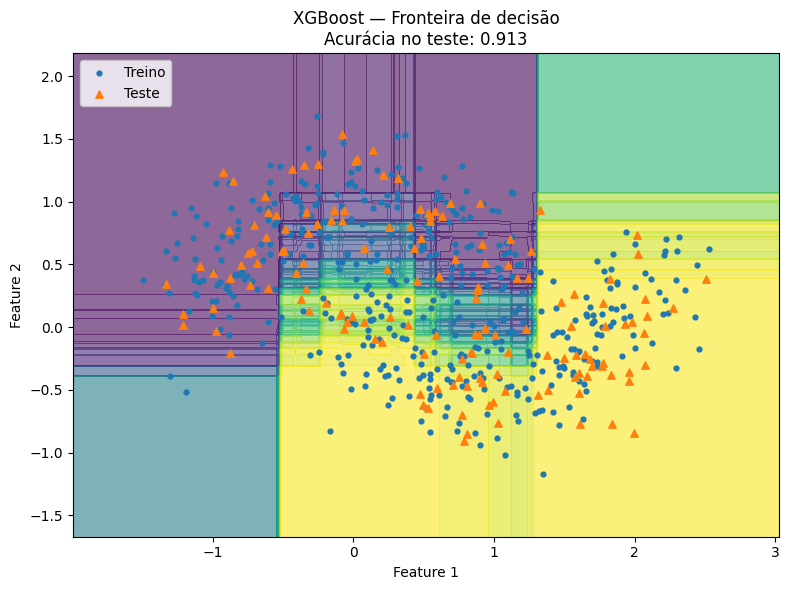

Explicação rápida:
1) Dados não-lineares (dois crescentes de lua) tornam o problema desafiante.
2) Boosting: várias árvores rasas, em sequência, onde cada nova corrige os erros da anterior.
3) A fronteira curva e detalhada emerge da combinação de árvores simples.
Nota: Usou XGBoost real


In [ ]:
# ==========================================
# EXEMPLO 1 — XGBoost super visual (2D)
# Classificação binária com fronteira de decisão
# ==========================================

# 1 Importações essenciais
import numpy as np
import matplotlib.pyplot as plt

# 2 Gerador de dados, divisão treino/teste e métricas
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 3 Tentar usar XGBoost; se não existir, usar GradientBoosting (fallback didático)
try:
    from xgboost import XGBClassifier
    ModelClass = XGBClassifier
    using_xgb = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    ModelClass = GradientBoostingClassifier
    using_xgb = False

# 4 Gerar dados não-lineares (dois crescentes de lua) com algum ruído
X, y = make_moons(n_samples=600, noise=0.25, random_state=42)

# 5 Separar treino e teste com estratificação (distribuição de classes equilibrada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6 Instanciar o modelo com hiperparâmetros simples (rápidos e didáticos)
if using_xgb:
    model = ModelClass(
        n_estimators=120,      # 7 número de árvores (iterações de boosting)
        max_depth=3,           # 8 árvores rasas = melhor generalização
        learning_rate=0.1,     # 9 passo de aprendizagem (peso das novas árvores)
        subsample=0.9,         # 10 amostragem de linhas (regularização)
        colsample_bytree=0.9,  # 11 amostragem de colunas (regularização)
        reg_lambda=1.0,        # 12 regularização L2
        random_state=42,
        n_jobs=-1,             # 13 usar todos os cores
        tree_method="hist",    # 14 algoritmo mais rápido
        eval_metric="logloss", # 15 métrica padrão
        use_label_encoder=False
    )
else:
    model = ModelClass(
        n_estimators=120,      # 7 número de árvores
        max_depth=3,           # 8 profundidade efetiva média
        learning_rate=0.1,     # 9 passo de aprendizagem
        subsample=0.9,         # 10 amostragem de linhas
        random_state=42
    )

# 16 Treinar o modelo no conjunto de treino
model.fit(X_train, y_train)

# 17 Avaliar no teste (métrica simples: acurácia)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# 18 Criar uma grelha densa de pontos (meshgrid) para desenhar a fronteira
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),   # 19 resolução da grelha (aumenta/diminui detalhe)
    np.linspace(y_min, y_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# 20 Obter a probabilidade da classe 1 para cada ponto da grelha
if hasattr(model, "predict_proba"):
    Z = model.predict_proba(grid)[:, 1]
else:
    Z = model.predict(grid)  # fallback “duro” 0/1
    Z = (Z - Z.min()) / (Z.max() - Z.min() + 1e-9)  # normalizar p/ visual

Z = Z.reshape(xx.shape)

# 21 Um único gráfico: fundo com fronteira + pontos de treino/teste
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=50, alpha=0.6)     # 22 fundo com “confiança” do modelo
plt.scatter(X_train[:, 0], X_train[:, 1], s=12, label="Treino")  # 23 pontos treino
plt.scatter(X_test[:, 0], X_test[:, 1], s=28, marker="^", label="Teste")  # 24 pontos teste
titulo = "XGBoost — Fronteira de decisão" if using_xgb else "Boosting (fallback) — Fronteira de decisão"
plt.title(f"{titulo}\nAcurácia no teste: {acc:.3f}")  # 25 incluir métrica no título
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 26 Explicação curta (pode ler em voz alta na aula)
print("Explicação rápida:")
print("1) Dados não-lineares (dois crescentes de lua) tornam o problema desafiante.")
print("2) Boosting: várias árvores rasas, em sequência, onde cada nova corrige os erros da anterior.")
print("3) A fronteira curva e detalhada emerge da combinação de árvores simples.")
print(f"Nota: {'Usou XGBoost real' if using_xgb else 'Usou fallback (GradientBoosting) por falta de xgboost'}")



### O que observar 👀

* **Forma da fronteira**: não é uma linha reta — é **curva** e **rica em detalhe**, fruto da soma de pequenas árvores.
* **Robustez com ruído**: mesmo com **ruído** nos dados, o modelo encontra uma boa fronteira.
* **Parâmetros que “mexem” na forma**:

  * `n_estimators` ↑ → fronteira mais detalhada (cuidado com overfitting).
  * `max_depth` ↑ → árvores mais complexas (mais risco de overfitting).
  * `learning_rate` ↓ → aprende mais devagar, pede mais árvores (muitas vezes melhora generalização).


